In [1]:
from src.helper import load_pickle, dump_pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = load_pickle("data/processed/X_train.pkl")
y_train = load_pickle("data/processed/y_train.pkl")

In [3]:
X_test = load_pickle("data/processed/X_test.pkl")
y_test = load_pickle("data/processed/y_test.pkl")

Step:

1. Bikin binning
2. Cari good and bad distribution in each binning
3. Hitung WOE
4. Plot WOE
5. Hitung IV nya

Summary 16 April 2023 jam 23 di step ini:
1. Overall udah berhasil ngelakuin binning, WOE, dan IV
2. Tapi besok pengen coba explore bagian WOE nya
3. Coba OHE categorical data sebelum WOE dan IV, karena gk ada missing values maka kita coba langsung OHE kan (tidak bisa)
4. Coba extract nama features dan IV, terus coba di sort buat ngeliat predictive power mana yang paling gede
5. Save as pkl file

Update 17 April 2023:
- ternyata ketika ngelakuin OHE terus WOE itu agak aneh, karena in the end kita mendapatkan result WOE yang sama

In [4]:
dataset = pd.concat([X_train, y_train], axis = 1)

In [5]:
dataset.drop(["SK_ID_CURR"], axis = 1, inplace=True)

In [6]:
test_set = pd.concat([X_test, y_test], axis = 1)

In [7]:
test_set.drop(["SK_ID_CURR"], axis = 1, inplace=True)

In [8]:
dataset_2 = dataset.copy()
test_set_2 = test_set.copy()

#### Binning Process

- Jika menggunakan jumlah bins/group terlalu sedikit, nanti kurang merepresentasikan data yang dimiliki
- Jika memiliki banyak jumlah bins/group nanti terlalu sedikit memberikan informasi

[Source: find the "best" num of binning](https://stats.stackexchange.com/a/810)

In [9]:
dataset_2

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0
...,...,...,...,...,...,...,...,...
206264,Cash loans,F,N,112500.0,405000.0,22099.5,405000.0,0
123969,Cash loans,F,Y,112500.0,1288350.0,37669.5,1125000.0,0
116922,Cash loans,M,N,157500.0,117000.0,14013.0,117000.0,1
118218,Cash loans,F,N,270000.0,900000.0,47952.0,900000.0,0


In [10]:
test_set_2

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET
54382,Cash loans,F,N,135000.0,1082214.0,31770.0,945000.0,0
252585,Cash loans,F,N,180000.0,1288350.0,37795.5,1125000.0,0
181435,Cash loans,F,N,112500.0,224149.5,26730.0,193500.0,0
116552,Cash loans,F,Y,112500.0,227520.0,15331.5,180000.0,0
255329,Cash loans,F,N,261000.0,904500.0,88245.0,904500.0,0
...,...,...,...,...,...,...,...,...
276887,Cash loans,F,N,90000.0,808650.0,29709.0,675000.0,0
216144,Revolving loans,F,N,90000.0,247500.0,12375.0,247500.0,0
162497,Cash loans,F,N,225000.0,1800000.0,74286.0,1800000.0,0
114900,Cash loans,F,N,202500.0,526491.0,29529.0,454500.0,0


### Calculate WOE

Log odds from 

`good_proportion` / `bad_proportion`

In [11]:
def woe(df, feature_name):
    # make probability analysis
    feature_name = df.groupby(feature_name).agg(num_observation=('TARGET','count'),
                                                good_loan_prob=('TARGET','mean')).reset_index()
    
    # find grade proportion
    feature_name['grade_proportion'] = feature_name['num_observation']/feature_name['num_observation'].sum()
    
    # find number of good loan
    feature_name['num_good_loan'] = feature_name['grade_proportion'] * feature_name['num_observation']

    # find number of bad loan
    feature_name['num_bad_loan'] = (1-feature_name['grade_proportion']) * feature_name['num_observation']

    # find good loan proportion
    feature_name['good_loan_prop'] = feature_name['num_good_loan'] / feature_name['num_good_loan'].sum()

    # find bad loan proportion
    feature_name['bad_loan_prop'] = feature_name['num_bad_loan'] / feature_name['num_bad_loan'].sum()

    # find Weight of Evidence
    feature_name['weight_of_evidence'] = np.log(feature_name['good_loan_prop'] / feature_name['bad_loan_prop'])

    # sort values by weight of evidence
    feature_name = feature_name.sort_values('weight_of_evidence').reset_index(drop=True)
    
    # find difference each good loan proportion
    feature_name['good_loan_prop_diff'] = feature_name['good_loan_prop'].diff().abs()

    # find difference each weight of evidence
    feature_name['diff_woe'] = feature_name['weight_of_evidence'].diff().abs()
    
    # find information value
    feature_name['information_value'] = (feature_name['good_loan_prop']-feature_name['bad_loan_prop']) * feature_name['weight_of_evidence']
    feature_name['information_value'] = feature_name['information_value'].sum()
    
    return feature_name

In [12]:
def plot_woe(data, xlabel_rotation=0):
    plt.figure(figsize=(8,4))
    sns.pointplot(x=data.columns[0], y='weight_of_evidence', data=data, markers='o', linestyles='--', color='blue')
    plt.title(str('Weight of Evidence by ' + data.columns[0]))
    plt.xticks(rotation = xlabel_rotation)

In [ ]:
def get_woe(data, feature_name):
    data_woe = 

### Numerical Data 

In [13]:
dataset_2['AMT_INCOME_TOTAL_bin'] = np.where((dataset['AMT_INCOME_TOTAL'] > 0)&(dataset['AMT_INCOME_TOTAL'] <= 100000),'0-100k',
                               np.where((dataset['AMT_INCOME_TOTAL'] > 100000)&(dataset['AMT_INCOME_TOTAL'] <= 150000), '100k-150k',
                               np.where((dataset['AMT_INCOME_TOTAL'] > 150000)&(dataset['AMT_INCOME_TOTAL'] <= 200000), '150k-200k',
                               np.where((dataset['AMT_INCOME_TOTAL'] > 200000)&(dataset['AMT_INCOME_TOTAL'] <= 250000), '200k-250k',
                               np.where((dataset['AMT_INCOME_TOTAL'] > 250000)&(dataset['AMT_INCOME_TOTAL'] <= 300000), '250k-300k','>300k')))))

In [18]:
woe(dataset_2, "AMT_INCOME_TOTAL_bin")

,AMT_INCOME_TOTAL_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,250k-300k,89,0.033708,0.055625,4.950625,84.049375,0.014737,0.066491,-1.506673,NaN,NaN,0.263623
1,>300k,121,0.074380,0.075625,9.150625,111.849375,0.027240,0.088483,-1.178114,0.012503,0.328560,0.263623
2,200k-250k,250,0.060000,0.156250,39.062500,210.937500,0.116284,0.166871,-0.361182,0.089044,0.816932,0.263623
3,0-100k,318,0.072327,0.198750,63.202500,254.797500,0.188146,0.201568,-0.068908,0.071862,0.292274,0.263623
4,150k-200k,329,0.091185,0.205625,67.650625,261.349375,0.201388,0.206751,-0.026284,0.013242,0.042624,0.263623
5,100k-150k,493,0.097363,0.308125,151.905625,341.094375,0.452204,0.269837,0.516318,0.250817,0.542602,0.263623


In [21]:
woe(dataset_2, "AMT_INCOME_TOTAL_bin")[["AMT_INCOME_TOTAL_bin", "weight_of_evidence"]].sort_values(by="AMT_INCOME_TOTAL_bin")

,AMT_INCOME_TOTAL_bin,weight_of_evidence
3,0-100k,-0.068908
5,100k-150k,0.516318
4,150k-200k,-0.026284
2,200k-250k,-0.361182
0,250k-300k,-1.506673
1,>300k,-1.178114


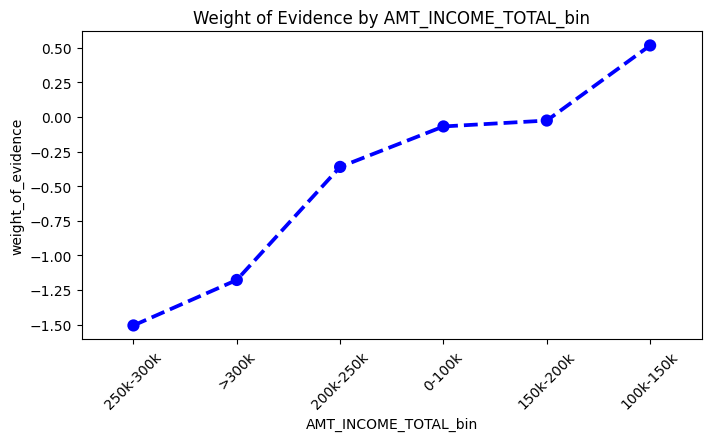

In [191]:
plot_woe(woe(dataset_2, "AMT_INCOME_TOTAL_bin"), 45)

In [24]:
dataset_2['AMT_CREDIT_bin'] = np.where((dataset['AMT_CREDIT']>0)&(dataset['AMT_CREDIT']<200000),'0-200k',
                              np.where((dataset['AMT_CREDIT']>200000)&(dataset['AMT_CREDIT']<=400000),'200k-400k',
                              np.where((dataset['AMT_CREDIT']>400000)&(dataset['AMT_CREDIT']<=600000),'400k-600k',
                              np.where((dataset['AMT_CREDIT']>600000)&(dataset['AMT_CREDIT']<=800000),'600k-800k',
                              np.where((dataset['AMT_CREDIT']>800000)&(dataset['AMT_CREDIT']<=1000000),'800k-1m','>1m')))))

In [25]:
woe(dataset_2, "AMT_CREDIT_bin")

,AMT_CREDIT_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,800k-1m,147,0.061224,0.091875,13.505625,133.494375,0.044976,0.102710,-0.825785,NaN,NaN,0.162183
1,0-200k,180,0.061111,0.112500,20.250000,159.750000,0.067436,0.122912,-0.600287,0.022460,0.225498,0.162183
2,600k-800k,229,0.061135,0.143125,32.775625,196.224375,0.109148,0.150975,-0.324405,0.041712,0.275882,0.162183
3,>1m,281,0.071174,0.175625,49.350625,231.649375,0.164346,0.178231,-0.081106,0.055198,0.243299,0.162183
4,400k-600k,337,0.091988,0.210625,70.980625,266.019375,0.236378,0.204675,0.144006,0.072032,0.225112,0.162183
5,200k-400k,426,0.100939,0.266250,113.422500,312.577500,0.377716,0.240497,0.451436,0.141339,0.307430,0.162183


In [26]:
woe(dataset_2, "AMT_CREDIT_bin")[["AMT_CREDIT_bin", "weight_of_evidence"]].sort_values(by="AMT_CREDIT_bin")

,AMT_CREDIT_bin,weight_of_evidence
1,0-200k,-0.600287
5,200k-400k,0.451436
4,400k-600k,0.144006
2,600k-800k,-0.324405
0,800k-1m,-0.825785
3,>1m,-0.081106


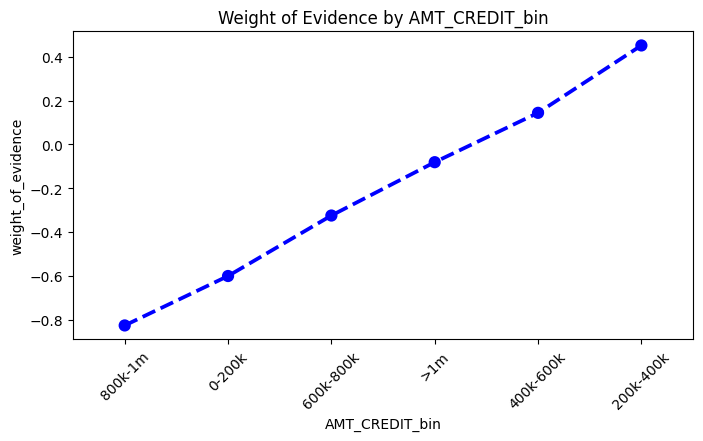

In [194]:
plot_woe(woe(dataset_2, "AMT_CREDIT_bin"), 45)

In [30]:
dataset_2['AMT_ANNUITY_bin'] =  np.where(dataset['AMT_ANNUITY']<=20000,'20k',
                          np.where((dataset['AMT_ANNUITY']>20000)&(dataset['AMT_ANNUITY']<=30000),'30k',
                          np.where((dataset['AMT_ANNUITY']>30000)&(dataset['AMT_ANNUITY']<=46000),'46k','>46k')))

In [31]:
woe(dataset_2, "AMT_ANNUITY_bin")

,AMT_ANNUITY_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,>46k,165,0.072727,0.103125,17.015625,147.984375,0.037756,0.128757,-1.226783,NaN,NaN,0.140578
1,46k,417,0.074341,0.260625,108.680625,308.319375,0.241152,0.268261,-0.106531,0.203396,1.120252,0.140578
2,30k,479,0.087683,0.299375,143.400625,335.599375,0.318193,0.291996,0.085916,0.077040,0.192447,0.140578
3,20k,539,0.079777,0.336875,181.575625,357.424375,0.402899,0.310986,0.258940,0.084707,0.173024,0.140578


In [33]:
woe(dataset_2, "AMT_ANNUITY_bin")[["AMT_ANNUITY_bin", "weight_of_evidence"]].sort_values(by="AMT_ANNUITY_bin")

,AMT_ANNUITY_bin,weight_of_evidence
3,20k,0.258940
2,30k,0.085916
1,46k,-0.106531
0,>46k,-1.226783


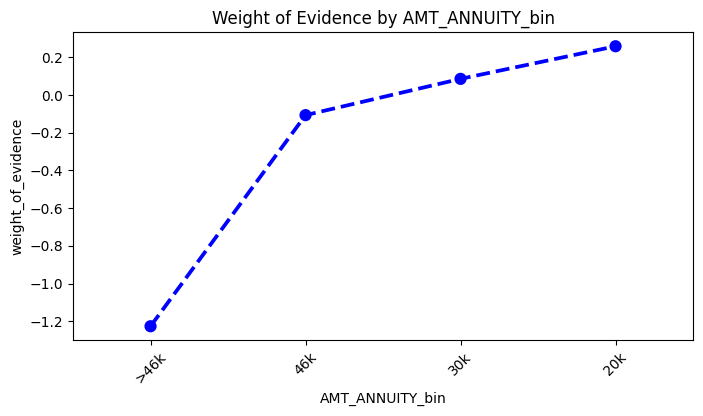

In [197]:
plot_woe(woe(dataset_2, "AMT_ANNUITY_bin"), 45)

In [34]:
dataset_2['AMT_GOODS_PRICE_bin'] = np.where(dataset['AMT_GOODS_PRICE']<=300000,'300k',
                              np.where((dataset['AMT_GOODS_PRICE']>300000)&(dataset['AMT_GOODS_PRICE']<=600000),'600k',
                              np.where((dataset['AMT_GOODS_PRICE']>600000)&(dataset['AMT_GOODS_PRICE']<=900000),'900k','1m')))

In [35]:
woe(dataset_2, "AMT_GOODS_PRICE_bin")

,AMT_GOODS_PRICE_bin,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,1m,234,0.072650,0.146250,34.222500,199.777500,0.078441,0.171672,-0.783240,NaN,NaN,0.134526
1,900k,339,0.061947,0.211875,71.825625,267.174375,0.164631,0.229587,-0.332579,0.086190,0.450661,0.134526
2,600k,491,0.089613,0.306875,150.675625,340.324375,0.345362,0.292446,0.166311,0.180731,0.498890,0.134526
3,300k,536,0.085821,0.335000,179.560000,356.440000,0.411567,0.306295,0.295424,0.066205,0.129113,0.134526


In [39]:
woe(dataset_2, "AMT_GOODS_PRICE_bin")[["AMT_GOODS_PRICE_bin", "weight_of_evidence"]]

,AMT_GOODS_PRICE_bin,weight_of_evidence
0,1m,-0.783240
1,900k,-0.332579
2,600k,0.166311
3,300k,0.295424


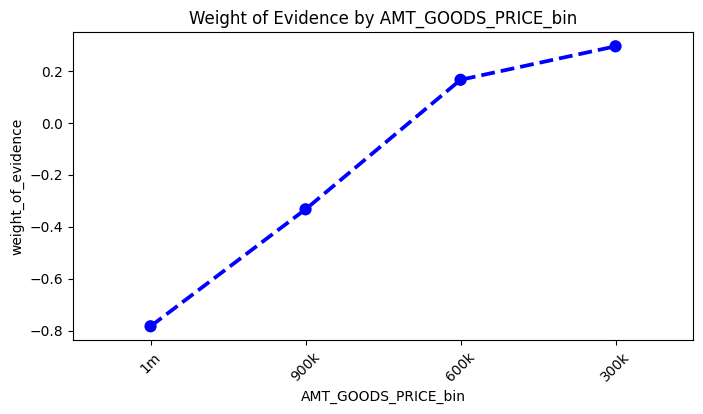

In [200]:
plot_woe(woe(dataset_2, "AMT_GOODS_PRICE_bin"), 45)

### Categorical Data 

In [201]:
woe(dataset_2, "NAME_CONTRACT_TYPE")

,NAME_CONTRACT_TYPE,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,Revolving loans,132,0.083333,0.0825,10.89,121.11,0.00802,0.5,-4.132614,NaN,NaN,2.370214
1,Cash loans,1468,0.079700,0.9175,1346.89,121.11,0.99198,0.5,0.685094,0.983959,4.817709,2.370214


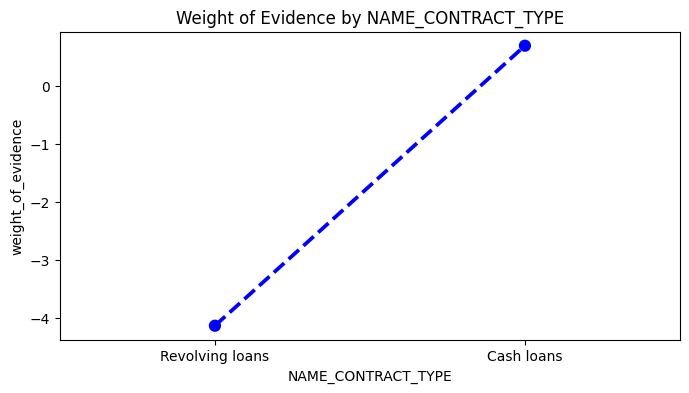

In [202]:
plot_woe(woe(dataset_2, "NAME_CONTRACT_TYPE"))

In [203]:
woe(dataset_2, "CODE_GENDER")

,CODE_GENDER,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,M,535,0.102804,0.334375,178.890625,356.109375,0.201503,0.5,-0.908804,NaN,NaN,0.411008
1,F,1065,0.068545,0.665625,708.890625,356.109375,0.798497,0.5,0.468123,0.596994,1.376927,0.411008


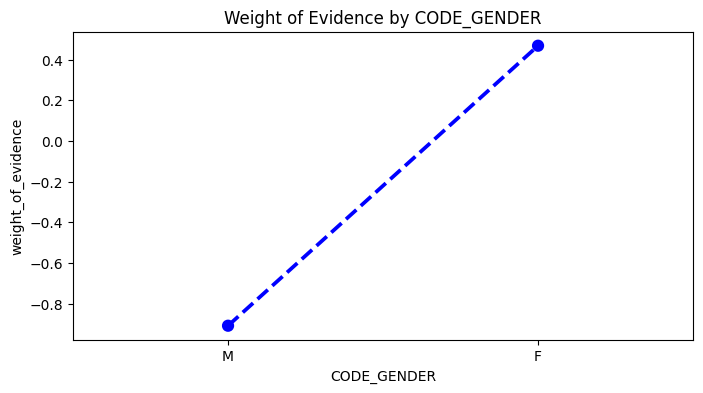

In [204]:
plot_woe(woe(dataset_2, "CODE_GENDER"))

In [205]:
woe(dataset_2, "FLAG_OWN_CAR")

,FLAG_OWN_CAR,num_observation,good_loan_prob,grade_proportion,num_good_loan,num_bad_loan,good_loan_prop,bad_loan_prop,weight_of_evidence,good_loan_prop_diff,diff_woe,information_value
0,Y,562,0.058719,0.35125,197.4025,364.5975,0.22669,0.5,-0.791026,NaN,NaN,0.335379
1,N,1038,0.091522,0.64875,673.4025,364.5975,0.77331,0.5,0.436072,0.546621,1.227098,0.335379


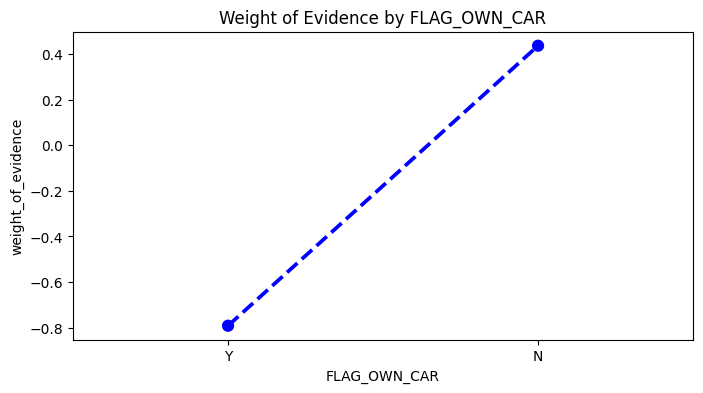

In [206]:
plot_woe(woe(dataset_2, "FLAG_OWN_CAR"))

#### Conclusion dari WOE Categorical Data

- yang col gender agak bias, karena WOE dari M lebih kecil daripada gender F

#### Extract IV and Features Name 

TODO: bikin function yang buat extract IV dan nama features nya terus di sorting

In [207]:
def extract_IV(data):
    result_dict = {"cols_name": [],
                  "iv_result": []}
    
    for col in data.columns:
        tmp_res = woe(data, col)
        result_dict["cols_name"].append(tmp_res.columns[0])
        result_dict["iv_result"].append(tmp_res["information_value"].values[0])
        
        final_result = pd.DataFrame.from_dict(result_dict, orient="index").transpose()
        final_result = final_result.sort_values(by="iv_result", ascending=False, ignore_index = True)
        
    return final_result

In [208]:
iv_data = extract_IV(dataset_2)

iv_data

,cols_name,iv_result
0,TARGET,2.405689
1,NAME_CONTRACT_TYPE,2.370214
2,AMT_GOODS_PRICE,1.427119
3,AMT_CREDIT,1.404717
4,AMT_ANNUITY,1.208323
5,AMT_INCOME_TOTAL,0.965209
6,CODE_GENDER,0.411008
7,FLAG_OWN_CAR,0.335379
8,AMT_INCOME_TOTAL_bin,0.263623
9,AMT_CREDIT_bin,0.162183


kita pakai cut off 0.5 dan tidak pakai gender

In [40]:
cols = ["FLAG_OWN_CAR", "AMT_INCOME_TOTAL_bin", "AMT_CREDIT_bin", "AMT_ANNUITY_bin", "AMT_GOODS_PRICE_bin"]

##### Validasi knowledge 

TIL, crosstab ini itu mirip contingency table

In [209]:
tst = pd.crosstab(dataset_2["AMT_CREDIT_bin"], dataset_2["TARGET"])

In [210]:
tst["Good Distribution"] = round(tst[0]/np.sum(tst[0]), 2)

In [211]:
tst

TARGET,0,1,Good Distribution
AMT_CREDIT_bin,,,
0-200k,169,11,0.11
200k-400k,383,43,0.26
400k-600k,306,31,0.21
600k-800k,215,14,0.15
800k-1m,138,9,0.09
>1m,261,20,0.18


#### Train 

In [212]:
# AMT_INCOME_TOTAL
dataset['AMT_INCOME_TOTAL_0_100k'] = np.where(dataset['AMT_INCOME_TOTAL']<=100000,1,0)
dataset['AMT_INCOME_TOTAL_100k_150k'] = np.where((dataset['AMT_INCOME_TOTAL']>100000)&(dataset['AMT_INCOME_TOTAL']<=150000),1,0)
dataset['AMT_INCOME_TOTAL_150k_200k'] = np.where((dataset['AMT_INCOME_TOTAL']>150000)&(dataset['AMT_INCOME_TOTAL']<=200000),1,0)
dataset['AMT_INCOME_TOTAL_200k_250k'] = np.where((dataset['AMT_INCOME_TOTAL']>200000)&(dataset['AMT_INCOME_TOTAL']<=250000),1,0)
dataset['AMT_INCOME_TOTAL_250k_300k'] = np.where((dataset['AMT_INCOME_TOTAL']>250000)&(dataset['AMT_INCOME_TOTAL']<=300000),1,0)
dataset['AMT_INCOME_TOTAL_>_300k'] = np.where(dataset['AMT_INCOME_TOTAL']>300000,1,0)

# AMT_CREDIT
dataset['AMT_CREDIT_0_200k'] = np.where(dataset['AMT_CREDIT']<=200000,1,0)
dataset['AMT_CREDIT_200k_400k'] = np.where((dataset['AMT_CREDIT']>200000)&(dataset['AMT_CREDIT']<=400000),1,0)
dataset['AMT_CREDIT_400k_600k'] = np.where((dataset['AMT_CREDIT']>400000)&(dataset['AMT_CREDIT']<=600000),1,0)
dataset['AMT_CREDIT_600k_800k'] = np.where((dataset['AMT_CREDIT']>600000)&(dataset['AMT_CREDIT']<=800000),1,0)
dataset['AMT_CREDIT_800k_1m'] = np.where((dataset['AMT_CREDIT']>800000)&(dataset['AMT_CREDIT']<=1000000),1,0)
dataset['AMT_CREDIT_1m'] = np.where(dataset['AMT_CREDIT']>1000000,1,0)

# AMT_ANNUITY
dataset['AMT_ANNUITY_20k'] = np.where(dataset['AMT_ANNUITY']<=20000,1,0)
dataset['AMT_ANNUITY_30k'] = np.where((dataset['AMT_ANNUITY']>20000)&(dataset['AMT_ANNUITY']<=30000),1,0)
dataset['AMT_ANNUITY_46k'] = np.where((dataset['AMT_ANNUITY']>30000)&(dataset['AMT_ANNUITY']<=46000),1,0)
dataset['AMT_ANNUITY_50k'] = np.where(dataset['AMT_ANNUITY']>46000,1,0)


# AMT_GOODS_PRICE
dataset['AMT_GOODS_PRICE_300k'] = np.where(dataset['AMT_GOODS_PRICE']<=300000,1,0)
dataset['AMT_GOODS_PRICE_600k'] = np.where((dataset['AMT_GOODS_PRICE']>300000)&(dataset['AMT_GOODS_PRICE']<=600000),1,0)
dataset['AMT_GOODS_PRICE_900k'] = np.where((dataset['AMT_GOODS_PRICE']>600000)&(dataset['AMT_GOODS_PRICE']<=900000),1,0)
dataset['AMT_GOODS_PRICE_1m'] = np.where(dataset['AMT_GOODS_PRICE']>1000000,1,0)

#### Test 

In [213]:
# AMT_INCOME_TOTAL
test_set['AMT_INCOME_TOTAL_0_100k'] = np.where(test_set['AMT_INCOME_TOTAL']<=100000,1,0)
test_set['AMT_INCOME_TOTAL_100k_150k'] = np.where((test_set['AMT_INCOME_TOTAL']>100000)&(test_set['AMT_INCOME_TOTAL']<=150000),1,0)
test_set['AMT_INCOME_TOTAL_150k_200k'] = np.where((test_set['AMT_INCOME_TOTAL']>150000)&(test_set['AMT_INCOME_TOTAL']<=200000),1,0)
test_set['AMT_INCOME_TOTAL_200k_250k'] = np.where((test_set['AMT_INCOME_TOTAL']>200000)&(test_set['AMT_INCOME_TOTAL']<=250000),1,0)
test_set['AMT_INCOME_TOTAL_250k_300k'] = np.where((test_set['AMT_INCOME_TOTAL']>250000)&(test_set['AMT_INCOME_TOTAL']<=300000),1,0)
test_set['AMT_INCOME_TOTAL_>_300k'] = np.where(test_set['AMT_INCOME_TOTAL']>300000,1,0)

# AMT_CREDIT
test_set['AMT_CREDIT_0_200k'] = np.where(test_set['AMT_CREDIT']<=200000,1,0)
test_set['AMT_CREDIT_200k_400k'] = np.where((test_set['AMT_CREDIT']>200000)&(test_set['AMT_CREDIT']<=400000),1,0)
test_set['AMT_CREDIT_400k_600k'] = np.where((test_set['AMT_CREDIT']>400000)&(test_set['AMT_CREDIT']<=600000),1,0)
test_set['AMT_CREDIT_600k_800k'] = np.where((test_set['AMT_CREDIT']>600000)&(test_set['AMT_CREDIT']<=800000),1,0)
test_set['AMT_CREDIT_800k_1m'] = np.where((test_set['AMT_CREDIT']>800000)&(test_set['AMT_CREDIT']<=1000000),1,0)
test_set['AMT_CREDIT_1m'] = np.where(test_set['AMT_CREDIT']>1000000,1,0)

# AMT_ANNUITY
test_set['AMT_ANNUITY_20k'] = np.where(test_set['AMT_ANNUITY']<=20000,1,0)
test_set['AMT_ANNUITY_30k'] = np.where((test_set['AMT_ANNUITY']>20000)&(test_set['AMT_ANNUITY']<=30000),1,0)
test_set['AMT_ANNUITY_46k'] = np.where((test_set['AMT_ANNUITY']>30000)&(test_set['AMT_ANNUITY']<=46000),1,0)
test_set['AMT_ANNUITY_50k'] = np.where(test_set['AMT_ANNUITY']>46000,1,0)


# AMT_GOODS_PRICE
test_set['AMT_GOODS_PRICE_300k'] = np.where(test_set['AMT_GOODS_PRICE']<=300000,1,0)
test_set['AMT_GOODS_PRICE_600k'] = np.where((test_set['AMT_GOODS_PRICE']>300000)&(test_set['AMT_GOODS_PRICE']<=600000),1,0)
test_set['AMT_GOODS_PRICE_900k'] = np.where((test_set['AMT_GOODS_PRICE']>600000)&(test_set['AMT_GOODS_PRICE']<=900000),1,0)
test_set['AMT_GOODS_PRICE_1m'] = np.where(test_set['AMT_GOODS_PRICE']>1000000,1,0)

#### Convert Categorical into OHE 

In [214]:
cat_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR"]

In [217]:
dataset_cat = dataset[cat_cols].copy()

In [218]:
test_set_cat = test_set[cat_cols].copy()

In [219]:
dataset_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR
185640,Cash loans,F,N
266989,Cash loans,F,N
37682,Cash loans,M,Y
280087,Cash loans,F,N
255967,Cash loans,F,Y
...,...,...,...
206264,Cash loans,F,N
123969,Cash loans,F,Y
116922,Cash loans,M,N
118218,Cash loans,F,N


In [220]:
test_set_cat.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR
54382,Cash loans,F,N
252585,Cash loans,F,N
181435,Cash loans,F,N
116552,Cash loans,F,Y
255329,Cash loans,F,N


In [221]:
from sklearn.preprocessing import OneHotEncoder

In [222]:
def fit_OHE(data):
    ohe_encoder = OneHotEncoder(handle_unknown="ignore")
    ohe_encoder.fit(data)
    
    return ohe_encoder

In [223]:
def transform_OHE(data, ohe_encoder):
    ohe_col = ohe_encoder.get_feature_names_out(data.columns)
    
    data_ohe = ohe_encoder.transform(data).toarray()
    data_ohe = pd.DataFrame(data = data_ohe,
                            columns = ohe_col,
                            index = data.index)
    
    return data_ohe, ohe_col

In [224]:
ohe_encoder = fit_OHE(data = dataset_cat)

In [225]:
dataset_cat_ohe, ohe_col = transform_OHE(data = dataset_cat,
                                         ohe_encoder = ohe_encoder)

In [226]:
test_set_cat_ohe, ohe_col = transform_OHE(data = test_set_cat,
                                          ohe_encoder = ohe_encoder)

In [227]:
dataset_cat_ohe

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y
185640,1.0,0.0,1.0,0.0,1.0,0.0
266989,1.0,0.0,1.0,0.0,1.0,0.0
37682,1.0,0.0,0.0,1.0,0.0,1.0
280087,1.0,0.0,1.0,0.0,1.0,0.0
255967,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
206264,1.0,0.0,1.0,0.0,1.0,0.0
123969,1.0,0.0,1.0,0.0,0.0,1.0
116922,1.0,0.0,0.0,1.0,1.0,0.0
118218,1.0,0.0,1.0,0.0,1.0,0.0


In [228]:
test_set_cat_ohe.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y
54382,1.0,0.0,1.0,0.0,1.0,0.0
252585,1.0,0.0,1.0,0.0,1.0,0.0
181435,1.0,0.0,1.0,0.0,1.0,0.0
116552,1.0,0.0,1.0,0.0,0.0,1.0
255329,1.0,0.0,1.0,0.0,1.0,0.0


#### Save as pkl 

Arrange final train dataset

In [229]:
dataset

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET,AMT_INCOME_TOTAL_0_100k,AMT_INCOME_TOTAL_100k_150k,...,AMT_CREDIT_800k_1m,AMT_CREDIT_1m,AMT_ANNUITY_20k,AMT_ANNUITY_30k,AMT_ANNUITY_46k,AMT_ANNUITY_50k,AMT_GOODS_PRICE_300k,AMT_GOODS_PRICE_600k,AMT_GOODS_PRICE_900k,AMT_GOODS_PRICE_1m
185640,Cash loans,F,N,135000.0,599778.0,28984.5,477000.0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
266989,Cash loans,F,N,112500.0,152820.0,18135.0,135000.0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
37682,Cash loans,M,Y,202500.0,540000.0,21546.0,540000.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
280087,Cash loans,F,N,157500.0,1350000.0,37255.5,1350000.0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
255967,Cash loans,F,Y,180000.0,410476.5,37777.5,373500.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206264,Cash loans,F,N,112500.0,405000.0,22099.5,405000.0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
123969,Cash loans,F,Y,112500.0,1288350.0,37669.5,1125000.0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
116922,Cash loans,M,N,157500.0,117000.0,14013.0,117000.0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
118218,Cash loans,F,N,270000.0,900000.0,47952.0,900000.0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [230]:
cols_to_drop = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR",
               "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]

In [231]:
dataset.drop(cols_to_drop, axis = 1, inplace = True)
test_set.drop(cols_to_drop, axis = 1, inplace = True)

In [232]:
dataset.head()

,TARGET,AMT_INCOME_TOTAL_0_100k,AMT_INCOME_TOTAL_100k_150k,AMT_INCOME_TOTAL_150k_200k,AMT_INCOME_TOTAL_200k_250k,AMT_INCOME_TOTAL_250k_300k,AMT_INCOME_TOTAL_>_300k,AMT_CREDIT_0_200k,AMT_CREDIT_200k_400k,AMT_CREDIT_400k_600k,...,AMT_CREDIT_800k_1m,AMT_CREDIT_1m,AMT_ANNUITY_20k,AMT_ANNUITY_30k,AMT_ANNUITY_46k,AMT_ANNUITY_50k,AMT_GOODS_PRICE_300k,AMT_GOODS_PRICE_600k,AMT_GOODS_PRICE_900k,AMT_GOODS_PRICE_1m
185640,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
266989,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
37682,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
280087,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
255967,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [233]:
test_set.head()

,TARGET,AMT_INCOME_TOTAL_0_100k,AMT_INCOME_TOTAL_100k_150k,AMT_INCOME_TOTAL_150k_200k,AMT_INCOME_TOTAL_200k_250k,AMT_INCOME_TOTAL_250k_300k,AMT_INCOME_TOTAL_>_300k,AMT_CREDIT_0_200k,AMT_CREDIT_200k_400k,AMT_CREDIT_400k_600k,...,AMT_CREDIT_800k_1m,AMT_CREDIT_1m,AMT_ANNUITY_20k,AMT_ANNUITY_30k,AMT_ANNUITY_46k,AMT_ANNUITY_50k,AMT_GOODS_PRICE_300k,AMT_GOODS_PRICE_600k,AMT_GOODS_PRICE_900k,AMT_GOODS_PRICE_1m
54382,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
252585,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
181435,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
116552,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
255329,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [234]:
final_dataset = pd.concat([dataset_cat_ohe, dataset], axis=1)

In [235]:
final_test_set = pd.concat([test_set_cat_ohe, test_set], axis = 1)

In [236]:
final_dataset

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,TARGET,AMT_INCOME_TOTAL_0_100k,AMT_INCOME_TOTAL_100k_150k,AMT_INCOME_TOTAL_150k_200k,...,AMT_CREDIT_800k_1m,AMT_CREDIT_1m,AMT_ANNUITY_20k,AMT_ANNUITY_30k,AMT_ANNUITY_46k,AMT_ANNUITY_50k,AMT_GOODS_PRICE_300k,AMT_GOODS_PRICE_600k,AMT_GOODS_PRICE_900k,AMT_GOODS_PRICE_1m
185640,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
266989,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
37682,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
280087,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
255967,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206264,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
123969,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
116922,1.0,0.0,0.0,1.0,1.0,0.0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
118218,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [237]:
final_test_set

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,TARGET,AMT_INCOME_TOTAL_0_100k,AMT_INCOME_TOTAL_100k_150k,AMT_INCOME_TOTAL_150k_200k,...,AMT_CREDIT_800k_1m,AMT_CREDIT_1m,AMT_ANNUITY_20k,AMT_ANNUITY_30k,AMT_ANNUITY_46k,AMT_ANNUITY_50k,AMT_GOODS_PRICE_300k,AMT_GOODS_PRICE_600k,AMT_GOODS_PRICE_900k,AMT_GOODS_PRICE_1m
54382,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
252585,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
181435,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
116552,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
255329,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276887,1.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
216144,0.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
162497,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
114900,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [238]:
dump_pickle(final_dataset, "data/processed/final_train_v3.pkl")
dump_pickle(final_test_set, "data/processed/final_test_v3.pkl")
dump_pickle(iv_data, "data/processed/iv_data_v2.pkl")